In [2]:
from sklearn import linear_model as lin
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import compose as com
from sklearn import impute as imp
from sklearn import preprocessing as pre
from sklearn import metrics as met
import numpy as np
import pandas as pd

titanic=pd.read_csv("../titanic/train.csv")
titanic.head(3)

titanic_df=titanic.drop(columns=["PassengerId","Name","Ticket","Cabin"])
obj_col=titanic_df.dropna().select_dtypes("object").columns
num_col=titanic_df.dropna().select_dtypes(np.number).columns.difference(["Survived"])
label="Survived"

columns=titanic_df.columns.difference([label])

num_pip=pip.make_pipeline(imp.SimpleImputer(strategy="mean"),pre.StandardScaler())
obj_pip=pip.make_pipeline(imp.SimpleImputer(strategy="most_frequent"),pre.OneHotEncoder(drop="first",handle_unknown="ignore"))

total_pip=com.make_column_transformer((num_pip,num_col),(obj_pip,obj_col),remainder="passthrough")

In [3]:
from sklearn import tree as tre

method=lambda x: tre.DecisionTreeClassifier(max_depth=x)

model_1=pip.make_pipeline(total_pip,method(None))
model_2=pip.make_pipeline(total_pip,method(3))
model_3=pip.make_pipeline(total_pip,method(5))

In [4]:
loocv=mod.KFold(n_splits=len(titanic))
result=[]
for x1,x2 in loocv.split(titanic):
    train=titanic.loc[x1]
    test=titanic.loc[x2]
    
    pred_result=[]
    for model in [model_1,model_2,model_3]:
        model.fit(X=train[columns],y=train[label])
        pred_y=model.predict(X=test[columns])
        pred_result.append(pred_y)
    
    result.append(pred_result)

In [5]:
from mlxtend import evaluate as eva

In [6]:
model1_result=np.array([x[0] for x in result]).ravel()
model2_result=np.array([x[1] for x in result]).ravel()
model3_result=np.array([x[2] for x in result]).ravel()

In [7]:
table_12=eva.mcnemar_table(y_target=titanic[label],y_model1=model1_result,y_model2=model2_result)
table_23=eva.mcnemar_table(y_target=titanic[label],y_model1=model2_result,y_model2=model3_result)
table_31=eva.mcnemar_table(y_target=titanic[label],y_model1=model3_result,y_model2=model1_result)

In [8]:
contingency_tables=eva.mcnemar_tables(titanic[label],*[model1_result,model2_result,model3_result])

In [9]:
for name in contingency_tables:
    print("비교된 모델 :",name)
    print(contingency_tables[name])

비교된 모델 : model_0 vs model_1
[[640.  56.]
 [ 89. 106.]]
비교된 모델 : model_0 vs model_2
[[645.  51.]
 [ 84. 111.]]
비교된 모델 : model_1 vs model_2
[[723.   6.]
 [  6. 156.]]


In [10]:
contingency_tables.keys()

dict_keys(['model_0 vs model_1', 'model_0 vs model_2', 'model_1 vs model_2'])

In [11]:
for name in contingency_tables:
    statitic,pvalue=eva.mcnemar(contingency_tables[name])
    print("비교 :",name)
    print("검정통계량 :",statitic)
    print("pvalue :",pvalue)

비교 : model_0 vs model_1
검정통계량 : 7.062068965517241
pvalue : 0.007873301783060812
비교 : model_0 vs model_2
검정통계량 : 7.5851851851851855
pvalue : 0.005884991805863098
비교 : model_1 vs model_2
검정통계량 : 0.08333333333333333
pvalue : 0.7728299926844475


프리드만 검정

In [160]:
kfold=mod.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
result=[]
for train_idx,test_idx in kfold.split(X=titanic[columns],y=titanic[label]):
    train_X=titanic.loc[train_idx,columns]
    train_y=titanic.loc[train_idx,label]
    test_X=titanic.loc[test_idx,columns]
    test_y=titanic.loc[test_idx,label]

    model_1.fit(X=train_X,y=train_y)
    model_2.fit(X=train_X,y=train_y)
    model_3.fit(X=train_X,y=train_y)

    acc_fun=lambda model : met.accuracy_score(y_true=test_y,y_pred=model.predict(test_X))
    acc_list=[acc_fun(model) for model in [model_1,model_2,model_3]]

    result.append(acc_list)

In [166]:
n,k=np.array(result).shape

In [178]:
from scipy import stats
friedman_test=stats.friedmanchisquare(*np.array(result).T)
print("검정통계량 :",friedman_test.statistic)
print("p-value :",friedman_test.pvalue)

검정통계량 : 6.222222222222231
p-value : 0.044551426244489496


In [167]:
rank_result=np.array([stats.rankdata(data) for data in result])

In [170]:
rank_result

array([[1. , 2. , 3. ],
       [1. , 2. , 3. ],
       [3. , 1.5, 1.5],
       [1. , 2.5, 2.5],
       [3. , 1.5, 1.5],
       [1. , 3. , 2. ],
       [1. , 2. , 3. ],
       [1. , 2. , 3. ],
       [1. , 2.5, 2.5],
       [1. , 3. , 2. ]])

In [171]:
n,k=np.array(result).shape

In [172]:
Q = (12 / (n * k * (k + 1))) * np.sum(rank_result.sum(axis=0)**2) - 3 * n * (k + 1)

In [175]:
Q

5.6000000000000085

In [155]:
import numpy as np
from scipy.stats import rankdata

# 예시 데이터 (각 샘플에 대해 그룹1, 그룹2, 그룹3의 값을 가진다)
data = np.array([
    [85, 90, 88],  # 샘플 1
    [88, 95, 90],  # 샘플 2
    [85, 92, 91]   # 샘플 3
])

# 1. 각 샘플 내에서 순위 부여 (동점 처리 포함)
ranks = np.array([rankdata(row) for row in data])

# 2. 각 그룹의 순위 합 계산
rank_sums = np.sum(ranks, axis=0)

# 3. 프리드만 검정 통계량 계산
n, k = data.shape  # n은 샘플 수, k는 그룹 수
Q = (12 / (n * k * (k + 1))) * np.sum(rank_sums**2) - 3 * n * (k + 1)

print(f"프리드만 검정 통계량 (Q): {Q}")


프리드만 검정 통계량 (Q): 6.0


In [179]:
data.T

array([[85, 88, 85],
       [90, 95, 92],
       [88, 90, 91]])

In [158]:
stats.friedmanchisquare(*data.T)

FriedmanchisquareResult(statistic=6.0, pvalue=0.04978706836786395)

In [132]:
sum((ri-((k+1)/2))**2)

0.56

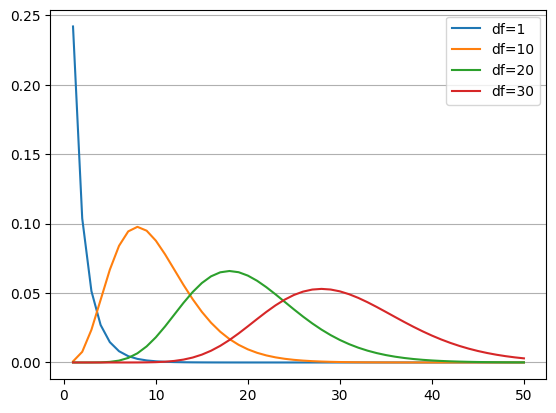

In [15]:
from numpy import linspace
from matplotlib import pyplot as plt

x=linspace(1,50,50)
df_list=[1,10,20,30]
y_list=[(i,stats.chi2.pdf(x,df=i)) for i in df_list]

for y in y_list:
    plt.plot(x,y[1],label=f"df={y[0]}")
plt.legend()
plt.grid(axis="y")

In [16]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"]="AppleGothic"
plt.rcParams["axes.unicode_minus"]=False

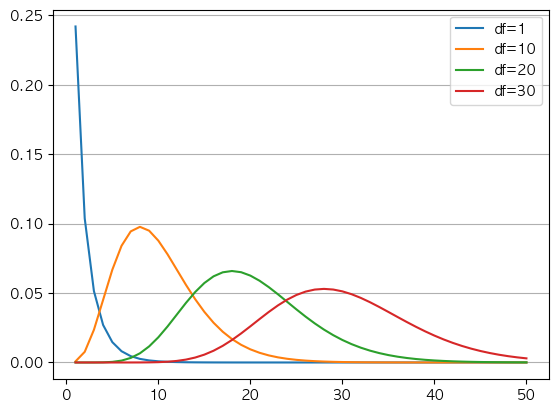

In [17]:
for y in y_list:
    plt.plot(x,y[1],label=f"df={y[0]}")
plt.legend()
plt.grid(axis="y")

In [18]:
stats.chi2.sf(17.279260780287473,df=9)

0.04451820272339232

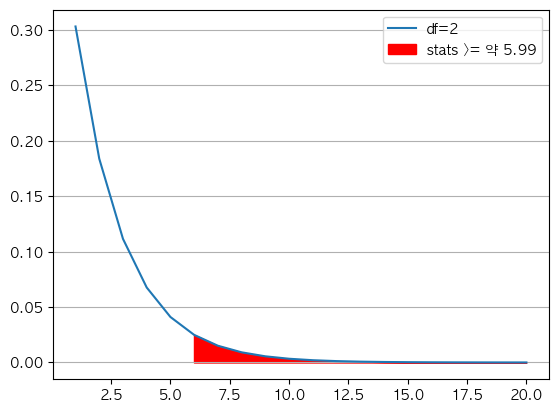

In [180]:
from scipy import optimize as opt
from scipy import stats as st
df=3-1
def opt_chi(stats,df=df):
    return st.chi2.sf(stats,df)-0.05

if opt.root_scalar(opt_chi,bracket=[1,100]).converged:
    root=opt.root_scalar(opt_chi,bracket=[1,100]).root

x=linspace(1,20,20)
y=st.chi2.pdf(x,df=df)

x_=linspace(root,20,20-int(root))
y_=st.chi2.pdf(x_,df=df)

plt.plot(x,y,label=f"df={df}")
plt.fill_between(x_,y1=y_,y2=0,color="red",label=f"stats >= 약 {round(root,2)}")
plt.legend()
plt.grid(axis="y")

In [20]:
opt.root_scalar(opt_chi,bracket=[1,100])

      converged: True
           flag: converged
 function_calls: 14
     iterations: 13
           root: 16.91897760462045
         method: brentq

In [21]:
st.chi2.sf(16.918977604620448,9)

0.050000000000000024

In [22]:
x=linspace(1,20,20)
y=st.chi2.pdf(x,df=df)

In [181]:
import scikit_posthocs as sp
from scipy.stats import rankdata

# def rank_rule(ls:list):
#     temp_ls=ls.copy()
#     temp_ls.sort()

#     def tied_rank(sorted_list):
#         return {x:np.array([rank+1 for rank,num in enumerate(sorted_list) if num==x]).mean() for x in set(sorted_list)}
    
#     rank_result=tied_rank(temp_ls)
#     return [rank_result[num] for num in ls]

rank_result=np.array([rankdata(rs) for rs in result])
model_0_mean=rank_result[:,0].mean()
model_1_mean=rank_result[:,1].mean()
model_2_mean=rank_result[:,2].mean()

print("모델1의 평균 :",model_0_mean,"\n모델2의 평균 :",model_1_mean,"\n모델3의 평균 :",model_2_mean,"\n") 
print(sp.posthoc_nemenyi_friedman(result))

모델1의 평균 : 1.4 
모델2의 평균 : 2.2 
모델3의 평균 : 2.4 

          0         1         2
0  1.000000  0.173535  0.065303
1  0.173535  1.000000  0.887683
2  0.065303  0.887683  1.000000


In [89]:
sp.

,0,1,2
0,1.000000,0.173535,0.065303
1,0.173535,1.000000,0.887683
2,0.065303,0.887683,1.000000


In [70]:
def rank_rule(ls:list):
    temp_ls=ls.copy()
    temp_ls.sort()

    def tied_rank(sorted_list):
        return {x:np.array([rank+1 for rank,num in enumerate(sorted_list) if num==x]).mean() for x in set(sorted_list)}
    
    rank_result=tied_rank(temp_ls)
    return [rank_result[num] for num in ls]

In [67]:
def tied_rank(sorted_list):
    return {x:np.array([rank+1 for rank,num in enumerate(sorted_list) if num==x]).mean() for x in set(sorted_list)}

In [82]:
np.array([rank_rule(rs) for rs in result])[:,1].mean()

2.2

In [60]:
test=[2,1,3,5,5]
test.sort()
list(enumerate(test))

[(0, 1), (1, 2), (2, 3), (3, 5), (4, 5)]

In [35]:
model_0_mean=np.array(result)[:,0].mean()
model_1_mean=np.array(result)[:,1].mean()
model_2_mean=np.array(result)[:,2].mean()

In [38]:
print(model_0_mean,model_1_mean,model_2_mean) 

0.7654556803995007 0.8103370786516854 0.8080774032459426


In [96]:
st.friedmanchisquare(*np.array(result).T)

FriedmanchisquareResult(statistic=6.222222222222231, pvalue=0.044551426244489496)

In [99]:
sp.posthoc_nemenyi_friedman(**np.array(result).T)

TypeError: scikit_posthocs._posthocs.posthoc_nemenyi_friedman() argument after ** must be a mapping, not numpy.ndarray